# Distintos valores de LR por capas

Como hemos visto en el notebook de [Transfer learning](13%20Transfer%20learning.ipynb), las primeras capas de un modelo lo que saben es reconocer formas básicas y mientras vamos avanzando en las capas, estas son capaces de reconocer patrones cada vez más complejos. Por lo que no tiene sentido modificar las primeras capas de un modelo, ya que como son capaces de reconocer formas básicas, no las deberíamos cambiar. Y lo que sí tiene sentido es cambiar las últimas capas, las que reconocen patrones más complejos.

Es decir, una red entrenada en imagenet, que es capaz de reconocer coches, por ejemplo, en sus últimas capas es capaz de reconocer el patrón de ruedas, faros, etc. Pero si nosotros vamos a usar esa red para clasificar perros y gatos, que sea capaz de reconocer ruedas no nos vale de mucho. Pero lo que si nos vale son sus primeras capas, las que son capaces de reconoder gradientes verticales, horizontales, cambios de color, etc.

Por lo que tendría más sentido que el learning rate en las primeras capas sea muy cercano a cero y en las últimas capas ya tenga un valor que haga que los pesos de esas capas se modifiquen para nuestro proposito

Esto con Pytorch es muy sencillo de hacer. Vamos a explicar cómo hacer que las primeras capas de un modelo tengan un learning rate de $10^{-6}$ y vaya aumentando linealmente hasta un valor de $10^{-3}$. Pero hay muchas más posibilidades, por ejemplo, que el cambio no sea lineal y sea logarítmico, o agrupar unas capas y ponerle un valor muy bajo y a las últimas un valor más alto, etc

## Ejemplo de entrenamiento con distinto LR por capas

Vamos a ver un ejemplo de entrenamiento de una red con distinto LR por capas, para reconocer entre gatos y perros, para ello usaremos el dataset [cats vs dogs](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset). Lo descargo desde kaggle y lo guardo en `data/cats_vs_dogs`.

Como ya lo hemos descargado y analizado en notebooks anteriores vamos directamente a hacer el dataframe

### Dataframe

Realizamos la misma limpieza que en el notebook anterior

In [1]:
import os
import pandas as pd
import cv2

df_cats = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Cat', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Cat')]})
df_cats['label'] = 0
df_cats['type'] = df_cats['path'].apply(lambda x: type(cv2.imread(x)))
df_cats = df_cats[df_cats.type != type(None)]

df_dogs = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Dog', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Dog')]})
df_dogs['label'] = 1
df_dogs['type'] = df_dogs['path'].apply(lambda x: type(cv2.imread(x)))
df_dogs = df_dogs[df_dogs.type != type(None)]

df = pd.concat([df_cats, df_dogs], axis=0).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)   # suffle df
df['height'] = df['path'].apply(lambda x: cv2.imread(x).shape[0])
df['width'] = df['path'].apply(lambda x: cv2.imread(x).shape[1])
df.head()

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 

,path,label,type,height,width
0,data/cats_vs_dogs/PetImages/Dog/1772.jpg,1,<class 'numpy.ndarray'>,375,500
1,data/cats_vs_dogs/PetImages/Cat/2263.jpg,0,<class 'numpy.ndarray'>,225,200
2,data/cats_vs_dogs/PetImages/Dog/10694.jpg,1,<class 'numpy.ndarray'>,333,500
3,data/cats_vs_dogs/PetImages/Cat/7509.jpg,0,<class 'numpy.ndarray'>,269,289
4,data/cats_vs_dogs/PetImages/Cat/5952.jpg,0,<class 'numpy.ndarray'>,314,336


In [2]:
median_shape = (int(df.height.median()), int(df.width.median()))
classes = {'cat': 0, 'dog': 1}

### Dataset

Creamos el dataset

In [3]:
import torch
import torchvision
import cv2

class DatasetCatsDogs(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.norm = torchvision.transforms.Normalize(self.mean, self.std)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(self.df.iloc[idx, 0])  # Read image
        if img.shape[0] != median_shape[0] or img.shape[1] != median_shape[1]:
            img = cv2.resize(img, median_shape) # Resize image
        img = torch.from_numpy(img).permute(2, 0, 1).float()    # Convert to tensor and permute dimensions
        img = img / 255.0  # Normalize image
        img = self.norm(img) # Standardize image
        label = self.df.loc[idx, 'label']
        return img, label

In [4]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['label'])
# Reset index
train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)
dataset = {
    'train': DatasetCatsDogs(train_split),
    'val': DatasetCatsDogs(val_split),
}

print(f"Había {len(df)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['val'])} imágenes de validación")

Había 24946 imágenes en el dataset, lo hemos dividido en 19956 imágenes de entrenamiento y 4990 imágenes de validación


Vemos una muestra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


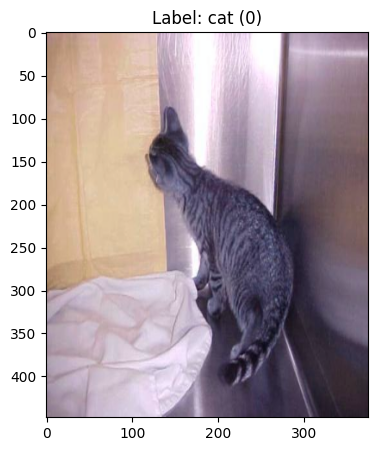

(448, 375, 3)


In [5]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(11)
idx = np.random.randint(0, len(dataset['train']))
sample_img, sample_label = dataset['train'][idx]

key = [k for k, v in classes.items() if v == sample_label][0]
fig = plt.figure(figsize=(5, 5))
img = sample_img.permute(1, 2, 0).numpy()
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # Unnormalize image
plt.imshow(img)
plt.title(f"Label: {key} ({sample_label})")
plt.show()
print(img.shape)

### Dataloaders

In [6]:
BS_train = 8
BS_test = 8

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_test, shuffle=False, num_workers=4),
}

In [7]:
batch_img, batch_label = next(iter(dataloader['train']))
print(batch_img.shape)

torch.Size([8, 3, 448, 375])


In [8]:
batch_img, batch_label = next(iter(dataloader['train']))
print(batch_img.shape)

torch.Size([8, 3, 448, 375])


### Model

In [9]:
from torchvision.models import resnet50, ResNet50_Weights

num_clases = len(classes)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, num_clases)
model = model.to(device)

### Entrenamiento

In [10]:
loss_fn = torch.nn.CrossEntropyLoss()

Aquí es donde viene la diferencia, antes definíamos el `optimizer` así

``` python
LR = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
```

Sin embargo, ahora no queremos un único valor de learning rate para todas las capas, así que primero creamos una lista que contendrá en cada item un diccionario con la capa del modelo y su respectivo valor de learning rate

In [11]:
min_lr = 1e-6
max_lr = 1e-3

params = []
layer_count = len(list(model.parameters()))
for i, (name, param) in enumerate(model.named_parameters()):
    lr = ((max_lr - min_lr) / (layer_count - 1)) * i + min_lr
    params.append({'params': param, 'lr': lr})

Como ahora tenemos una lista con el valor del learning rate para cada capa, ya podemos crear el `optimizer`

In [12]:
optimizer = torch.optim.Adam(params, weight_decay=1e-5)

El resto del código es igual que hasta ahora

In [13]:
num_prints = 2

def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    mul = 1
    model.train()
    mean_loss = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        preds = model(X)
        loss = loss_fn(preds, y)
        mean_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch+1) % int(len(dataloader)/num_prints) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            mul += 1
    
    return mean_loss/num_batches


def val_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            # X and y to device
            X, y = X.to(device), y.to(device)
            
            preds = model(X)
            val_loss += loss_fn(preds, y).item()
            correct += (preds.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    return val_loss, correct

In [14]:
epochs = 12
losses_train_freeze = []
losses_val_freeze = []
accuracies_val_freeze = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    mean_loss =  train_loop(dataloader['train'], model, loss_fn, optimizer, device)
    losses_train_freeze.append(mean_loss)
    mean_loss, accuracy = val_loop(dataloader['val'], model, loss_fn, device)
    losses_val_freeze.append(mean_loss)
    accuracies_val_freeze.append(accuracy)
print("Done!")

Epoch 1
-------------------------------


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.141406  [ 9968/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


loss: 0.003416  [19944/19956]


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 96.3%, Avg loss: 0.096856 

Epoch 2
-------------------------------


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.323727  [ 9968/19956]


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.306596  [19944/19956]


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 96.7%, Avg loss: 0.083574 

Epoch 3
-------------------------------


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.064790  [ 9968/19956]


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.016374  [19944/19956]


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 96.7%, Avg loss: 0.084064 

Epoch 4
-------------------------------


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.010218  [ 9968/19956]


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


loss: 0.075112  [19944/19956]


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 96.6%, Avg loss: 0.077363 

Epoch 5
-------------------------------


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


loss: 0.439424  [ 9968/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.000754  [19944/19956]


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 96.2%, Avg loss: 0.099701 

Epoch 6
-------------------------------


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.000958  [ 9968/19956]


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


loss: 0.197796  [19944/19956]


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 97.4%, Avg loss: 0.069288 

Epoch 7
-------------------------------


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


loss: 0.000000  [ 9968/19956]


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.014380  [19944/19956]


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 96.4%, Avg loss: 0.089860 

Epoch 8
-------------------------------


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


loss: 0.001894  [ 9968/19956]


Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.002193  [19944/19956]


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 95.9%, Avg loss: 0.114448 

Epoch 9
-------------------------------


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


loss: 0.008173  [ 9968/19956]


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


loss: 0.003870  [19944/19956]


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 97.1%, Avg loss: 0.076898 

Epoch 10
-------------------------------


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


loss: 0.000072  [ 9968/19956]


Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


loss: 0.000063  [19944/19956]


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 96.9%, Avg loss: 0.087146 

Epoch 11
-------------------------------


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


loss: 0.000639  [ 9968/19956]


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


loss: 0.000144  [19944/19956]


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 97.1%, Avg loss: 0.086631 

Epoch 12
-------------------------------


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


loss: 0.022734  [ 9968/19956]


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


loss: 0.001041  [19944/19956]


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 96.8%, Avg loss: 0.080062 

Done!
